## End-to-end Kubeflow Pipeline in Jupyter Notebook

**Steps in the pipeline**

- Run hyper-parameter tuning
- Extract optimal hyper-parameter
- Train using optimal hyper-parameter
- Serve the trained model

### Install libraries

In [ ]:
%%writefile requirements.txt
tensorflow==2.1.0
tensorflow-datasets==2.1.0
https://storage.googleapis.com/ml-pipeline/release/latest/kfp.tar.gz
pillow

In [ ]:
!pip3 install -r requirements.txt --user

In [ ]:
# restart kernel
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

restartkernel() 

### Import Libraries

In [1]:
import kfp
import kfp.dsl as dsl
import kfp.gcp as gcp
from kfp import components
import json
from string import Template

### Define Pipeline

Set the values of `PROJECT_ID`, `BUCKET` and execute.

In [2]:
def convert_result(result) -> str:
    import json
    hyperparameters = json.loads(result)
    args = []
    for param in hyperparameters:
        args.append("{0}={1}".format(param["name"], param["value"]))
    # join args to create argument string
    return " ".join(args)


@dsl.pipeline(
    name="Fashion-MNIST", description="A pipeline to train and serve the Fashion MNIST example."
)
def fashion_mnist_pipeline(
    name="fashion-mnist-{{workflow.uid}}",
    katib_namespace="kubeflow-akumar340",
    goal=0.9,
    max_trial_count=3,
    parallel_trial_count=3,
    training_steps=5,
    training_image="gcr.io/<GCP_PROJECT_ID>/kubeflow-fashion-mnist-train-keras:latest",
    training_namespace="kubeflow",
    export_dir="gs://<GCS_BUCKET_NAME>/export/004",
    serving_name="fashion-mnist-notebook",
    serving_namespace="kubeflow",
    serving_export_dir="gs://<GCS_BUCKET_NAME>/export",
    transformer_image="gcr.io/<GCP_PROJECT_ID>/fashion-mnist-processing:latest"

):


    ### Step 1: Hyper-parameter tuning with Katib
    objectiveConfig = {
      "type": "maximize",
      "goal": goal,
      "objectiveMetricName": "val_accuracy",
      "additionalMetricNames" : ["loss", "accuracy"]
    }
    algorithmConfig = {"algorithmName" : "random"}
    metricsCollectorSpec = {
      "collector": {
        "kind": "StdOut"
      }
    }
    parameters = [
      {"name": "--tf-learning-rate", "parameterType": "double", "feasibleSpace": {"min": "0.001","max": "0.05"}},
    ]
    
    rawTemplate = {
        "apiVersion": "batch/v1",
        "kind": "Job",
        "metadata": {
            "name": "{{.Trial}}",
            "namespace": "{{.NameSpace}}"
        },
        "spec": {
            "template": {
                "spec": {
                    "restartPolicy": "Never",
                    "containers": [
                        {"name": "{{.Trial}}",
                         "image": str(training_image),
                         "imagePullPolicy": "Always",
                         "command": [
                             "python /opt/model.py --tf-mode=local {{- with .HyperParameters}} {{- range .}} {{.Name}}={{.Value}} {{- end}} {{- end}}"
                         ]
                         }
                    ]
                }
            }
        }
    }

    trialTemplate = {
        "goTemplate": {
            "rawTemplate": json.dumps(rawTemplate)
        }
    }


    katib_experiment_launcher_op = components.load_component_from_url(
        'https://raw.githubusercontent.com/kubeflow/pipelines/master/components/kubeflow/katib-launcher/component.yaml')
    katib_op = katib_experiment_launcher_op(
        experiment_name=name,
        experiment_namespace=katib_namespace,
        parallel_trial_count=parallel_trial_count,
        max_trial_count=max_trial_count,
        objective=str(objectiveConfig),
        algorithm=str(algorithmConfig),
        trial_template=str(trialTemplate),
        parameters=str(parameters),
        metrics_collector=str(metricsCollectorSpec),
        delete_finished_experiment=False)
    
    ### Step 2 : convert the optimized result to extract optimal hyperparameters
    
    convert_op = components.func_to_container_op(convert_result)
    op2 = convert_op(katib_op.output)

    ## Step 3 : training
    training_template = Template("""
                                    {
                                        "apiVersion": "kubeflow.org/v1",
                                        "kind": "TFJob",
                                        "metadata": {
                                            "generateName": "tfjob",
                                            "name": "$name",
                                            "namespace": "$namespace"
                                        },
                                        "spec": {
                                            "tfReplicaSpecs": {
                                            "Chief": {
                                                "replicas": 1,
                                                "restartPolicy": "OnFailure",
                                                "template": {
                                                "spec": {
                                                    "containers": [
                                                    {
                                                        "name": "tensorflow",
                                                        "image": "$image",
                                                        "command": [
                                                        "python",
                                                        "/opt/model.py",
                                                        "--tf-export-dir=$export",
                                                        "--tf-mode=gcs",
                                                        "--tf-train-steps=$training_steps",
                                                        "$args"
                                                        ],
                                                        "env": [
                                                        {
                                                            "name": "GOOGLE_APPLICATION_CREDENTIALS",
                                                            "value": "/var/secrets/user-gcp-sa.json"
                                                        }
                                                        ],
                                                        "volumeMounts": [
                                                        {
                                                            "name": "sa",
                                                            "mountPath": "/var/secrets",
                                                            "readOnly": true
                                                        }
                                                        ]
                                                    }
                                                    ],
                                                    "volumes": [
                                                    {
                                                        "name": "sa",
                                                        "secret": {
                                                        "secretName": "user-gcp-sa"
                                                        }
                                                    }
                                                    ]
                                                }
                                                }
                                            },
                                            "Worker": {
                                                "replicas": 2,
                                                "restartPolicy": "OnFailure",
                                                "template": {
                                                "spec": {
                                                    "containers": [
                                                    {
                                                        "name": "tensorflow",
                                                        "image": "$image",
                                                        "command": [
                                                        "python",
                                                        "/opt/model.py",
                                                        "--tf-export-dir=$export",
                                                        "--tf-mode=gcs",
                                                        "--tf-train-steps=$training_steps",
                                                        "$args"
                                                        ],
                                                        "env": [
                                                        {
                                                            "name": "GOOGLE_APPLICATION_CREDENTIALS",
                                                            "value": "/var/secrets/user-gcp-sa.json"
                                                        }
                                                        ],
                                                        "volumeMounts": [
                                                        {
                                                            "name": "sa",
                                                            "mountPath": "/var/secrets",
                                                            "readOnly": true
                                                        }
                                                        ]
                                                    }
                                                    ],
                                                    "volumes": [
                                                    {
                                                        "name": "sa",
                                                        "secret": {
                                                        "secretName": "user-gcp-sa"
                                                        }
                                                    }
                                                    ]
                                                }
                                                }
                                            }
                                            }
                                        }
                                        }
                                    """)

    trainingjson = training_template.substitute({ 'name': str(name),
                                        'namespace': str(training_namespace),
                                        'image': str(training_image),
                                        'export': str(export_dir),
                                        'training_steps': training_steps,
                                        'args': op2.output})

    trainingdeployment = json.loads(trainingjson)

    train = dsl.ResourceOp(
        name="train",
        k8s_resource=trainingdeployment,
        action="apply",
        success_condition="status.replicaStatuses.Worker.succeeded==2,status.replicaStatuses.Chief.succeeded==1"
    )
    
    ### Step 4: serving model
    kfserving_template = Template("""
                                    {
                                      "apiVersion": "serving.kubeflow.org/v1alpha2",
                                      "kind": "InferenceService",
                                      "metadata": {
                                        "labels": {
                                          "controller-tools.k8s.io": "1.0"
                                        },
                                        "name": "$name",
                                        "namespace": "$namespace"
                                      },
                                      "spec": {
                                        "default": {
                                          "predictor": {
                                            "minReplicas": 1,
                                            "serviceAccountName": "kf-user",
                                            "tensorflow": {
                                              "storageUri": "$bucket"
                                            }
                                          },
                                          "transformer": {
                                            "serviceAccountName": "kf-user",
                                            "minReplicas": 1,
                                            "custom": {
                                              "container": {
                                                "image": "$transformer",
                                                "name": "user-container",
                                                "imagePullPolicy": "Always"
                                              }
                                            }
                                          }
                                        }
                                      }
                                    }
                                """)

    kfservingjson = kfserving_template.substitute({ 'name': str(serving_name),
                                'namespace': str(serving_namespace),
                                'bucket': str(serving_export_dir),
                                'transformer': str(transformer_image)})

    kfservingdeployment = json.loads(kfservingjson)

    serve = dsl.ResourceOp(
        name="serve",
        k8s_resource=kfservingdeployment,
        action="apply",
        success_condition="status.url"
    )
    serve.after(train)


### Create pipeline and experiment

In [3]:
pipeline = kfp.Client().create_run_from_pipeline_func(fashion_mnist_pipeline, arguments={})

/home/jovyan/.local/lib/python3.6/site-packages/kfp/components/_data_passing.py:168: UserWarning: Missing type name was inferred as "Float" based on the value "0.9".
  warnings.warn('Missing type name was inferred as "{}" based on the value "{}".'.format(type_name, str(value)))
/home/jovyan/.local/lib/python3.6/site-packages/kfp/components/_data_passing.py:168: UserWarning: Missing type name was inferred as "Integer" based on the value "3".
  warnings.warn('Missing type name was inferred as "{}" based on the value "{}".'.format(type_name, str(value)))
/home/jovyan/.local/lib/python3.6/site-packages/kfp/components/_data_passing.py:168: UserWarning: Missing type name was inferred as "Integer" based on the value "5".
  warnings.warn('Missing type name was inferred as "{}" based on the value "{}".'.format(type_name, str(value)))
/home/jovyan/.local/lib/python3.6/site-packages/kfp/components/_data_passing.py:189: UserWarning: There are no registered serializers from type "bool" to type "Boo

### Test Predictions

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import json
import base64
from tensorflow.keras.preprocessing.image import save_img, img_to_array
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
tfds.disable_progress_bar()


#### Create sample images

In [7]:
ds_train = tfds.load(name="fashion_mnist:1.0.0", split="train")

NUM_EXAMPLES=5
samples=[]

count=0
labels=[]
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

for row in ds_train.take(NUM_EXAMPLE):
    image, label = row["image"], row["label"]
    
    # preprocessing
    image = image.numpy() #/ 255.0
    image = image.reshape(28, 28, 1)
    count += 1
    save_img('fashion_mnist_{0}.jpg'.format(count),image)
    labels.append(class_names[label])

print(labels)

['Dress', 'Ankle boot', 'Sneaker', 'Shirt', 'Dress']


#### Test predictions of images

Acutal label: Dress, Predicted label: Trouser


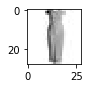

Acutal label: Ankle boot, Predicted label: Ankle boot


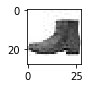

Acutal label: Sneaker, Predicted label: Sneaker


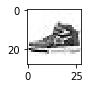

Acutal label: Shirt, Predicted label: Shirt


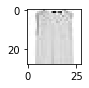

Acutal label: Dress, Predicted label: Dress


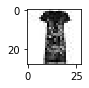

In [8]:
for index in range(NUM_EXAMPLES):
    data = None
    # read image
    img_array = None
    with open("fashion_mnist_{0}.jpg".format(index + 1), "rb") as image_file:
        encoded_bytes = base64.b64encode(image_file.read())
        # result: string (in utf-8)
        encoded_string = encoded_bytes.decode('utf-8')
        samples.append(encoded_string)
        data = json.dumps({"instances": [encoded_string]})
        
    
    # make predictions
    serving_name = "fashion-mnist-notebook"
    # Get cluster_ip : echo $(kubectl -n istio-system get service kfserving-ingressgateway -o jsonpath='{.status.loadBalancer.ingress[0].ip}')
    cluster_ip = "104.197.120.32"

    # set header
    headers={"Host": "{0}.kubeflow.example.com".format(serving_name)}
    
    # make post request and send data for predictions
    response = requests.post("http://{0}/v1/models/{1}:predict".format(cluster_ip, serving_name), 
                             data = data, 
                             headers = headers)
    predicted_label = response.json()['predictions'][0]
    actual_label = labels[index]
    # print predictions
    print('Acutal label: {0}, Predicted label: {1}'.format(actual_label, predicted_label))
    
    # display image 
    img = mpimg.imread("fashion_mnist_{0}.jpg".format(index + 1))
    plt.figure(figsize=(1,1))
    imgplot = plt.imshow(img, cmap=plt.cm.binary)
    plt.show()
  